In [132]:
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
import numpy as np
import hvplot.pandas
# from alpha_vantage.timeseries import TimeSeries
# from alpha_vantage.cryptocurrencies import CryptoCurrencies
import json
import questionary
from MCForecastTools import MCSimulation
%matplotlib inline

In [2]:
API_Key = 'A9HTPYBVOW6MI2HN'

In [83]:
stock_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=SPY&apikey={API_Key}&datatype=csv'
r = requests.get(stock_url)
print(r)

<Response [200]>


In [95]:
import requests

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=BTC&market=CNY&apikey={API_Key}&datatype=csv'
# url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=SPY&apikey={API_Key}&datatype=csv'
r = requests.get(url)
pd.read_csv(url,index_col='timestamp')

open (CNY)     high (CNY)      low (CNY)    close (CNY)  \
timestamp                                                                
2022-02-18  256792.621551  257501.664798  255425.430000  257484.932214   
2022-02-17  278075.010636  279920.348451  253988.012301  256792.558170   
2022-02-16  282329.713785  282362.164857  274484.096700  278075.010636   
2022-02-15  269597.041314  283638.848340  268906.758843  282329.777166   
2022-02-14  266540.239065  271539.415440  263351.604336  269597.041314   
...                   ...            ...            ...            ...   
2019-05-30   54802.381650   57513.567306   50736.490500   52413.171474   
2019-05-29   55248.393747   55458.375000   53281.871460   54797.184408   
2019-05-28   55474.347012   55765.709469   53941.224003   55240.597884   
2019-05-27   54587.139774   56461.822992   54437.940900   55498.431792   
2019-05-26   50850.576300   55394.994000   49648.999302   54599.118783   

            open (USD)  high (USD)  low (USD)  close (USD)        volume  \
timestamp                                                                  
2022-02-18    40515.71    40627.58   40300.00     40624.94   1214.125000   
2022-02-17    43873.56    44164.71   40073.21     40515.70  47245.994940   
2022-02-16    44544.85    44549.97   43307.00     43873.56  28471.872700   
2022-02-15    42535.94    44751.40   42427.03     44544.86  38095.195760   
2022-02-14    42053.65    42842.40   41550.56     42535.94  34010.130600   
...                ...         ...        ...          ...           ...   
2019-05-30     8646.50     9074.26    8005.00      8269.54  70379.998521   
2019-05-29     8716.87     8750.00    8406.60      8645.68  33880.865922   
2019-05-28     8752.52     8798.49    8510.63      8715.64  31470.551534   
2019-05-27     8612.54     8908.32    8589.00      8756.32  51886.768793   
2019-05-26     8023.00     8740.00    7833.42      8614.43  49652.144567   

            market cap (USD)  
timestamp                     
2022-02-18       1214.125000  
2022-02-17      47245.994940  
2022-02-16      28471.872700  
2022-02-15      38095.195760  
2022-02-14      34010.130600  
...                      ...  
2019-05-30      70379.998521  
2019-05-29      33880.865922  
2019-05-28      31470.551534  
2019-05-27      51886.768793  
2019-05-26      49652.144567  

[1000 rows x 10 columns]

:Overlay
   .Curve.I  :Curve   [Date]   (close)
   .Curve.II :Curve   [Date]   (close)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


'done'

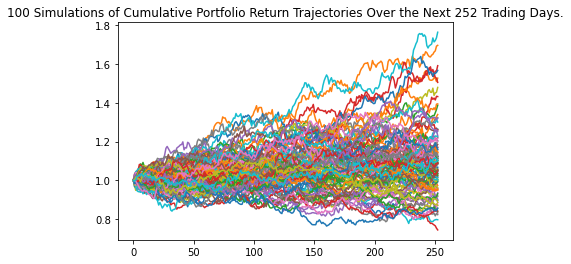

In [151]:
def display_data(apikey, ticker1, ticker2, is_etf, num_trading_day=252, num_sim=100):

    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker1}&outputsize=full&apikey={API_Key}&datatype=csv'
    df_base = pd.read_csv(url)
    df_base['Date'] = pd.to_datetime(df_base['timestamp'])
    df_base = df_base.set_index('Date')
    df_plot_base = df_base.hvplot.line(
            x = 'Date',
            y = 'close'
        )

    if is_etf == 'y':
        url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker2}&outputsize=full&apikey={API_Key}&datatype=csv'
        df = pd.read_csv(url)
        df['Date'] = pd.to_datetime(df['timestamp'])
        df = df.set_index('Date')

        df_plot = df.hvplot.line(
            x = 'Date',
            y = 'close'
        )

        p = df_plot_base * df_plot

    elif is_etf == 'n':
        url2 = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={ticker2}&market=CNY&outputsize=full&apikey={apikey}&datatype=csv'
        df = pd.read_csv(url2)
        df['Date'] = pd.to_datetime(df['timestamp'])
        df = df.set_index('Date')

        df_plot = df.hvplot.line(
            x = 'Date',
            y = 'close (USD)'
        )

        p = df_plot_base + df_plot

    else:
        return "Sorry, inputs are incorrect, please try again is_etf is y/n option."
    
    display(p)

    t1 = df_base[['open', 'high', 'low', 'close', 'volume']]
    t2 = df[['open', 'high', 'low', 'close', 'volume']]
    to_merge_dict = {ticker1: t1, ticker2: t2}
    merged_df = pd.concat(to_merge_dict.values(), axis=1, keys=to_merge_dict.keys())
    simulation = MCSimulation(
        portfolio_data = merged_df,
        weights=[0.25, 0.75],
        num_simulation = num_sim,
        num_trading_days = num_trading_day)
    simulation.calc_cumulative_return()
    simulation.plot_simulation()
    return 'done'
    # return df, df_base

    

display_data(apikey=API_Key, ticker1='VOO',ticker2='VYM', is_etf='y', num_trading_day=252, num_sim=100)



In [5]:
#a = df.sort_values(by ='Science', ascending = 0)
descend_SP500_df = SP500_api.sort_values(by ='timestamp', ascending = 1)

descend_SP500_df

open    high    low  close  volume
timestamp                                      
2020-10-15  12.00  12.000  12.00  12.00     100
2020-10-16  12.00  12.000  12.00  12.00       0
2020-10-19  12.00  12.000  12.00  12.00       0
2020-10-20  12.00  12.000  12.00  12.00       0
2020-10-21  12.00  12.000  12.00  12.00       0
...           ...     ...    ...    ...     ...
2022-02-14  32.60  34.800  32.60  33.20   54090
2022-02-15  35.50  35.880  34.46  34.87   49656
2022-02-16  34.84  35.315  34.43  35.07   33082
2022-02-17  34.16  34.250  32.25  33.40   57425
2022-02-18  33.05  33.150  32.02  33.00   49753

[340 rows x 5 columns]

In [6]:
# Create DataFrame for close
SP500_close = descend_SP500_df.filter(['timestamp', 'close'])

SP500_close

close
timestamp        
2020-10-15  12.00
2020-10-16  12.00
2020-10-19  12.00
2020-10-20  12.00
2020-10-21  12.00
...           ...
2022-02-14  33.20
2022-02-15  34.87
2022-02-16  35.07
2022-02-17  33.40
2022-02-18  33.00

[340 rows x 1 columns]

<AxesSubplot:title={'center':'SP500 Close Prices Sept 28, 2021 - Feb 17, 2022'}, xlabel='timestamp', ylabel='Close Prices'>

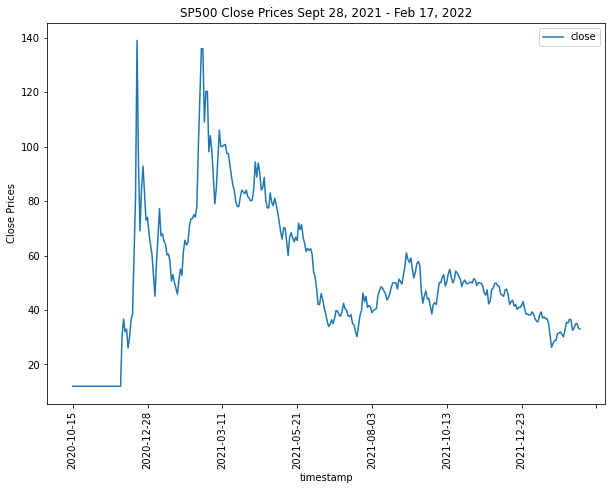

In [7]:
SP500_close.plot.line(
    y='close',
    xlabel='timestamp',
    ylabel='Close Prices',
    rot=90,
    title='SP500 Close Prices Sept 28, 2021 - Feb 17, 2022',
    figsize=(10,7)

)

In [8]:
SP500_daily_returns = (SP500_close['close'].pct_change().dropna()).to_frame()

SP500_daily_returns

close
timestamp           
2020-10-16  0.000000
2020-10-19  0.000000
2020-10-20  0.000000
2020-10-21  0.000000
2020-10-22  0.000000
...              ...
2022-02-14  0.021224
2022-02-15  0.050301
2022-02-16  0.005736
2022-02-17 -0.047619
2022-02-18 -0.011976

[339 rows x 1 columns]

In [120]:
test_crypto_api = pd.read_csv(f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=BTC&market=CNY&apikey={API_Key}&datatype=csv').set_index('timestamp')

In [10]:
test_crypto_api.head()

open (CNY)     high (CNY)      low (CNY)    close (CNY)  \
timestamp                                                                
2022-02-18  256792.621551  257501.664798  255425.430000  257484.932214   
2022-02-17  278075.010636  279920.348451  253988.012301  256792.558170   
2022-02-16  282329.713785  282362.164857  274484.096700  278075.010636   
2022-02-15  269597.041314  283638.848340  268906.758843  282329.777166   
2022-02-14  266540.239065  271539.415440  263351.604336  269597.041314   

            open (USD)  high (USD)  low (USD)  close (USD)       volume  \
timestamp                                                                 
2022-02-18    40515.71    40627.58   40300.00     40624.94   1214.12500   
2022-02-17    43873.56    44164.71   40073.21     40515.70  47245.99494   
2022-02-16    44544.85    44549.97   43307.00     43873.56  28471.87270   
2022-02-15    42535.94    44751.40   42427.03     44544.86  38095.19576   
2022-02-14    42053.65    42842.40   41550.56     42535.94  34010.13060   

            market cap (USD)  
timestamp                     
2022-02-18        1214.12500  
2022-02-17       47245.99494  
2022-02-16       28471.87270  
2022-02-15       38095.19576  
2022-02-14       34010.13060

## Analyzing the Performance

In [121]:
#a = df.sort_values(by ='Science', ascending = 0)
ascend_df = test_crypto_api.sort_values(by ='timestamp', ascending = 1)

ascend_df

open (CNY)     high (CNY)      low (CNY)    close (CNY)  \
timestamp                                                                
2019-05-26   50850.576300   55394.994000   49648.999302   54599.118783   
2019-05-27   54587.139774   56461.822992   54437.940900   55498.431792   
2019-05-28   55474.347012   55765.709469   53941.224003   55240.597884   
2019-05-29   55248.393747   55458.375000   53281.871460   54797.184408   
2019-05-30   54802.381650   57513.567306   50736.490500   52413.171474   
...                   ...            ...            ...            ...   
2022-02-14  266540.239065  271539.415440  263351.604336  269597.041314   
2022-02-15  269597.041314  283638.848340  268906.758843  282329.777166   
2022-02-16  282329.713785  282362.164857  274484.096700  278075.010636   
2022-02-17  278075.010636  279920.348451  253988.012301  256792.558170   
2022-02-18  256792.621551  257501.664798  255425.430000  257484.932214   

            open (USD)  high (USD)  low (USD)  close (USD)        volume  \
timestamp                                                                  
2019-05-26     8023.00     8740.00    7833.42      8614.43  49652.144567   
2019-05-27     8612.54     8908.32    8589.00      8756.32  51886.768793   
2019-05-28     8752.52     8798.49    8510.63      8715.64  31470.551534   
2019-05-29     8716.87     8750.00    8406.60      8645.68  33880.865922   
2019-05-30     8646.50     9074.26    8005.00      8269.54  70379.998521   
...                ...         ...        ...          ...           ...   
2022-02-14    42053.65    42842.40   41550.56     42535.94  34010.130600   
2022-02-15    42535.94    44751.40   42427.03     44544.86  38095.195760   
2022-02-16    44544.85    44549.97   43307.00     43873.56  28471.872700   
2022-02-17    43873.56    44164.71   40073.21     40515.70  47245.994940   
2022-02-18    40515.71    40627.58   40300.00     40624.94   1214.125000   

            market cap (USD)  
timestamp                     
2019-05-26      49652.144567  
2019-05-27      51886.768793  
2019-05-28      31470.551534  
2019-05-29      33880.865922  
2019-05-30      70379.998521  
...                      ...  
2022-02-14      34010.130600  
2022-02-15      38095.195760  
2022-02-16      28471.872700  
2022-02-17      47245.994940  
2022-02-18       1214.125000  

[1000 rows x 10 columns]

In [122]:
# Create DataFrame for close
BTC_close = ascend_df.filter(['timestamp', 'close (USD)'])



BTC_close

close (USD)
timestamp              
2019-05-26      8614.43
2019-05-27      8756.32
2019-05-28      8715.64
2019-05-29      8645.68
2019-05-30      8269.54
...                 ...
2022-02-14     42535.94
2022-02-15     44544.86
2022-02-16     43873.56
2022-02-17     40515.70
2022-02-18     40624.94

[1000 rows x 1 columns]

<AxesSubplot:title={'center':'BTC Close Prices May 26, 2019 - Feb 17, 2022'}, xlabel='Timestamp', ylabel='Close Prices'>

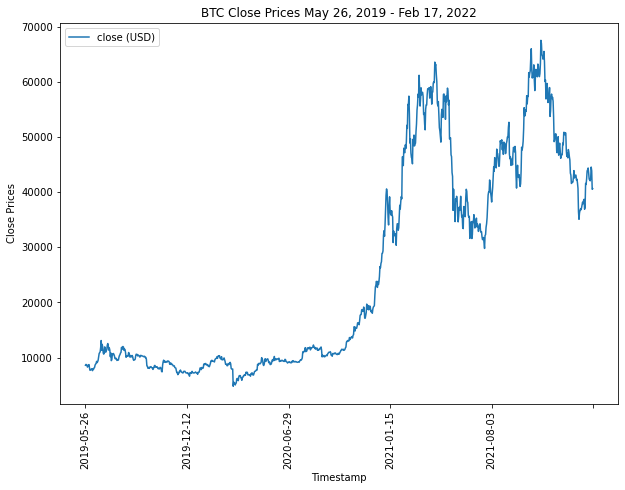

In [13]:
BTC_close.plot.line(
    y='close (USD)',
    xlabel='Timestamp',
    ylabel='Close Prices',
    rot=90,
    title='BTC Close Prices May 26, 2019 - Feb 17, 2022',
    figsize=(10,7)

)

In [125]:
BTC_daily_returns = (BTC_close['close (USD)'].pct_change().dropna()).to_frame()

BTC_daily_returns


close (USD)
timestamp              
2019-05-27     0.016471
2019-05-28    -0.004646
2019-05-29    -0.008027
2019-05-30    -0.043506
2019-05-31     0.034519
...                 ...
2022-02-14     0.011468
2022-02-15     0.047229
2022-02-16    -0.015070
2022-02-17    -0.076535
2022-02-18     0.002696

[999 rows x 1 columns]

In [15]:
# Generate summary statistics for the `daily_returns_df` DataFrame
BTC_daily_returns.describe()


count    999.000000
mean       0.002380
std        0.040051
min       -0.395048
25%       -0.016045
50%        0.001431
75%        0.021256
max        0.195361
Name: close (USD), dtype: float64

<AxesSubplot:title={'center':'Daily % Returns'}, xlabel='Days', ylabel='Daily % Returns'>

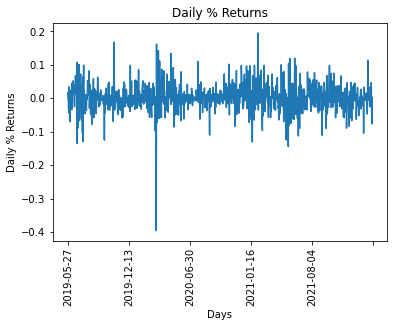

In [16]:
BTC_daily_returns.plot(
    x='timestamp',
    y='% returns',
    xlabel='Days',
    ylabel='Daily % Returns',
    rot=90,
    title='Daily % Returns'
)

In [17]:
#BTC_close["close (USD)"]
#daily_returns =

#daily_returns_df = BTC_close.concat(['daily_returns'])

#daily_returns_df = BTC_close.join(daily_returns.set_index('Col1'), on='Col3')

In [18]:
# Calculate and plot the cumulative returns of the 4 fund portfolios and the S&P 500
cumulative_returns = (1 + BTC_daily_returns).cumprod()
columns = ['cumulative_returns']
cumulative_returns.columns = columns

# Review the cumulative returns DataFrame
cumulative_returns.head()

timestamp
2019-05-27    1.016471
2019-05-28    1.011749
2019-05-29    1.003628
2019-05-30    0.959964
2019-05-31    0.993101
Name: close (USD), dtype: float64

<AxesSubplot:title={'center':'Cumulative % Returns'}, xlabel='Days', ylabel='Cumulative % Returns'>

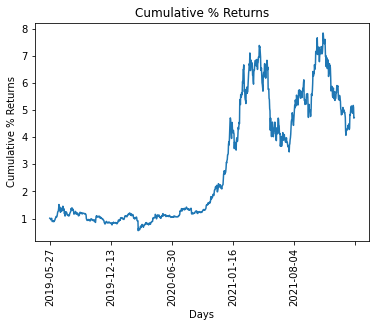

In [19]:
cumulative_returns.plot(
    x='',
    y='',
    rot=90,
    xlabel='Days',
    ylabel='Cumulative % Returns',
    title='Cumulative % Returns'
)

### Analyze the Volatility

Analyze the volatility of portfolios and of the S&P 500 Index by using box plots.

<AxesSubplot:title={'center':'Box Plot of Daily Returns'}>

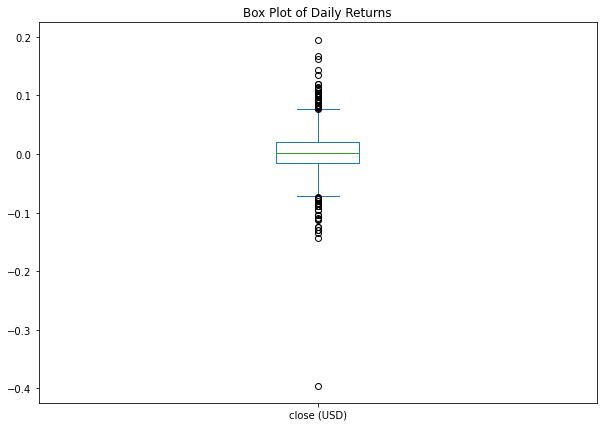

In [20]:
# Use the daily return data to create box plots to visualize the volatility of the 4 funds and the S&P 500 
# Include a title parameter and adjust the figure size
BTC_daily_returns.plot(kind = "box", figsize = (10, 7), title = "Box Plot of Daily Returns")

### Analyze the Risk

Evaluate the risk profile of each portfolio by using the standard deviation and the beta.

In [21]:
# Calculate and sort the standard deviation for all 4 portfolios and the S&P 500
# Review the standard deviations sorted smallest to largest
BTC_daily_std_dv = BTC_daily_returns.std()
BTC_daily_std_dv

0.040050512344455

In [22]:
# Calculate and sort the annualized standard deviation (252 trading days) of the 4 portfolios and the S&P 500
# Review the annual standard deviations smallest to largest
BTC_annualized_std_dv = BTC_daily_std_dv * np.sqrt(252)
BTC_annualized_std_dv

0.6357821732649024

<AxesSubplot:title={'center':'BTC 21-Day Rolling Standard Deviations'}, xlabel='timestamp'>

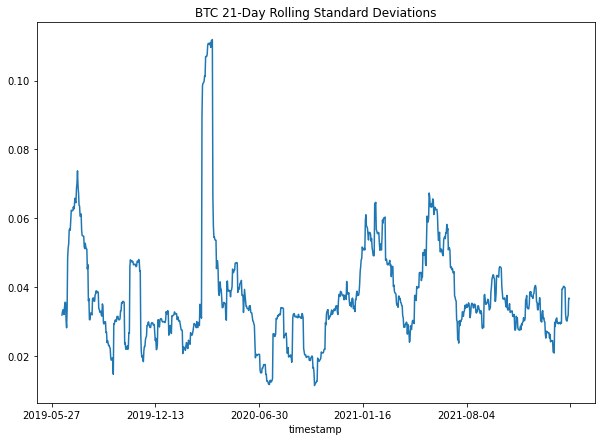

In [23]:
# Using the daily returns DataFrame and a 21-day rolling window, 
# plot the rolling standard deviation of the 4 portfolios and the S&P 500
# Include a title parameter and adjust the figure size
BTC_annualized_std_dv_21roll = BTC_daily_returns.rolling(window=21).std()
BTC_annualized_std_dv_21roll.plot(figsize = (10, 7), title="BTC 21-Day Rolling Standard Deviations")

### Analyze the Risk-Return Profile

To determine the overall risk of an asset or portfolio, quantitative analysts and investment managers consider not only its risk metrics but also its risk-return profile. After all, if you have two portfolios that each offer a 10% return but one has less risk, you’d probably invest in the smaller-risk portfolio. For this reason, you need to consider the Sharpe ratios for each portfolio.

In [24]:
# Use 252 as the number of trading days in the year
year_trading_days = 252

# Calculate the annual average return data for the for fund portfolios and the S&P 500
BTC_annual_avg_return = BTC_daily_returns.mean() * year_trading_days

# Review the annual average returns sorted from lowest to highest

BTC_annual_avg_return

0.5997762765379506

In [25]:
# Calculate the annualized Sharpe Ratios for each of the 4 portfolios and the S&P 500.
sharpe_ratios = BTC_annual_avg_return/BTC_annualized_std_dv


# Review the Sharpe ratios 
sharpe_ratios

0.9433675585113493

In [26]:
# Visualize the Sharpe ratios as a bar chart
# Include a title parameter and adjust the figure size
#sharpe_ratios.plot.bar(title = "Sharpe Ratios")

### Diversify the Portfolio

Your analysis is nearing completion. Now, you need to evaluate how the portfolios react relative to the broader market. Based on your analysis so far, choose two portfolios that you’re most likely to recommend as investment options.

In [126]:
# Calculate the variance of the S&P 500 using a rolling 60-day window.
sp500_var = SP500_daily_returns.rolling(window=60).var().dropna()

sp500_var

close
timestamp           
2021-01-12  0.064252
2021-01-13  0.064346
2021-01-14  0.064381
2021-01-15  0.064544
2021-01-19  0.064536
...              ...
2022-02-14  0.002464
2022-02-15  0.002510
2022-02-16  0.002477
2022-02-17  0.002326
2022-02-18  0.002316

[280 rows x 1 columns]

In [127]:
# Calculate the covariance using a 60-day rolling window 
# Review the last five rows of the covariance data
BTC_covariance_rolling_60 = BTC_daily_returns.rolling(window=60).cov(BTC_daily_returns)
BTC_daily_returns.head()

close (USD)
timestamp              
2019-05-27     0.016471
2019-05-28    -0.004646
2019-05-29    -0.008027
2019-05-30    -0.043506
2019-05-31     0.034519

In [129]:
# Calculate the beta based on the 60-day rolling covariance compared to the market (S&P 500)
# Review the last five rows of the beta information
BTC_beta_60_roll = (BTC_covariance_rolling_60['close (USD)'] / sp500_var['close']).dropna()
BTC_beta_60_roll

timestamp
2021-01-12    0.024926
2021-01-13    0.026496
2021-01-14    0.026618
2021-01-15    0.027806
2021-01-19    0.027628
                ...   
2022-02-14    0.359067
2022-02-15    0.361678
2022-02-16    0.366186
2022-02-17    0.431324
2022-02-18    0.432934
Length: 280, dtype: float64

In [130]:
# Calculate the average of the 60-day rolling beta
avg_beta_60_rolling = BTC_beta_60_roll.mean()
avg_beta_60_rolling

0.44194825142873145

<AxesSubplot:title={'center':'BTC SP500 : 60-Day Rolling Variance'}, xlabel='Days', ylabel='Beta'>

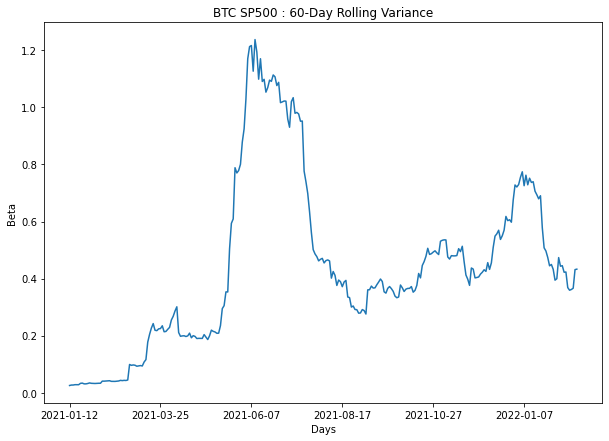

In [131]:
# Plot the rolling beta 
# Include a title parameter and adjust the figure size
BTC_beta_60_roll.plot(
    xlabel='Days',
    ylabel='Beta',
    figsize=(10,7), 
    title='BTC SP500 : 60-Day Rolling Variance'
)

In [138]:
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=SPY&outputsize=full&apikey={API_Key}&datatype=csv'
df_base = pd.read_csv(url)
df_base['Date'] = pd.to_datetime(df_base['timestamp'])
df_base = df_base.set_index('Date')
display(df_base.head())


url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=BITW&outputsize=full&apikey={API_Key}&datatype=csv'
df_base2 = pd.read_csv(url)
df_base2['Date'] = pd.to_datetime(df_base2['timestamp'])
df_base2 = df_base2.set_index('Date')
display(df_base2.head())

timestamp    open      high     low   close     volume
Date                                                               
2022-02-18  2022-02-18  437.33  438.6600  431.82  434.23  132642896
2022-02-17  2022-02-17  443.22  446.5652  436.42  437.06  102259108
2022-02-16  2022-02-16  443.93  448.0550  441.94  446.60   84863585
2022-02-15  2022-02-15  443.73  446.2800  443.18  446.10   88659503
2022-02-14  2022-02-14  439.92  441.6000  435.34  439.02  123006262

timestamp   open    high    low  close  volume
Date                                                       
2022-02-18  2022-02-18  33.05  33.150  32.02  33.00   49753
2022-02-17  2022-02-17  34.16  34.250  32.25  33.40   57425
2022-02-16  2022-02-16  34.84  35.315  34.43  35.07   33082
2022-02-15  2022-02-15  35.50  35.880  34.46  34.87   49656
2022-02-14  2022-02-14  32.60  34.800  32.60  33.20   54090

## Monte Carlo Simulation to Forecast 1, 3, 5 yr time periods

In [ ]:
def mc_custom(ticker1="SPY", ticker2, num_trading_days=252, num_sim=500, apikey):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=SPY&outputsize=full&apikey={api}&datatype=csv'
df_base = pd.read_csv(url)
df_base['Date'] = pd.to_datetime(df_base['timestamp'])
df_base = df_base.set_index('Date')
display(df_base.head())


url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=BITW&outputsize=full&apikey={API_Key}&datatype=csv'
df_base2 = pd.read_csv(url)
df_base2['Date'] = pd.to_datetime(df_base2['timestamp'])
df_base2 = df_base2.set_index('Date')
display(df_base2.head())

In [141]:
spy = df_base[['open', 'high', 'low', 'close', 'volume']]
bitw = df_base2[['open', 'high', 'low', 'close', 'volume']]

to_merge_dict = {"SPY": spy, "BITW": bitw}
merged_df = pd.concat(to_merge_dict.values(), axis=1, keys=to_merge_dict.keys())
merged_df

# Configure the Monte Carlo simulation to forecast 1 year cumulative returns
# The weights are equal
# Run 500 samples.
MC_3_year_cumulative = MCSimulation(
    portfolio_data = merged_df,
    weights=[0.25, 0.75],
    num_simulation = 500,
    num_trading_days = 252 
)

# Review the simulation input data
MC_3_year_cumulative.portfolio_data.head()

SPY                                            BITW          \
                open      high       low     close     volume   open    high   
Date                                                                           
1999-11-01  136.5000  137.0000  135.5625  135.5625    4006500    NaN     NaN   
1999-11-02  135.9687  137.2500  134.5937  134.5937    6516900    NaN     NaN   
1999-11-03  136.0000  136.3750  135.1250  135.5000    7222300    NaN     NaN   
1999-11-04  136.7500  137.3593  135.7656  136.5312    7907500    NaN     NaN   
1999-11-05  138.6250  139.1093  136.7812  137.8750    7431500    NaN     NaN   
...              ...       ...       ...       ...        ...    ...     ...   
2022-02-14  439.9200  441.6000  435.3400  439.0200  123006262  32.60  34.800   
2022-02-15  443.7300  446.2800  443.1800  446.1000   88659503  35.50  35.880   
2022-02-16  443.9300  448.0550  441.9400  446.6000   84863585  34.84  35.315   
2022-02-17  443.2200  446.5652  436.4200  437.0600  102259108  34.16  34.250   
2022-02-18  437.3300  438.6600  431.8200  434.2300  132642896  33.05  33.150   

                                   
              low  close   volume  
Date                               
1999-11-01    NaN    NaN      NaN  
1999-11-02    NaN    NaN      NaN  
1999-11-03    NaN    NaN      NaN  
1999-11-04    NaN    NaN      NaN  
1999-11-05    NaN    NaN      NaN  
...           ...    ...      ...  
2022-02-14  32.60  33.20  54090.0  
2022-02-15  34.46  34.87  49656.0  
2022-02-16  34.43  35.07  33082.0  
2022-02-17  32.25  33.40  57425.0  
2022-02-18  32.02  33.00  49753.0  

[5613 rows x 10 columns]

SPY                                                     BITW  \
                open      high       low     close   volume daily_return open   
Date                                                                            
1999-11-01  136.5000  137.0000  135.5625  135.5625  4006500          NaN  NaN   
1999-11-02  135.9687  137.2500  134.5937  134.5937  6516900    -0.007147  NaN   
1999-11-03  136.0000  136.3750  135.1250  135.5000  7222300     0.006734  NaN   
1999-11-04  136.7500  137.3593  135.7656  136.5312  7907500     0.007610  NaN   
1999-11-05  138.6250  139.1093  136.7812  137.8750  7431500     0.009842  NaN   

                                               
           high low close volume daily_return  
Date                                           
1999-11-01  NaN NaN   NaN    NaN          NaN  
1999-11-02  NaN NaN   NaN    NaN          NaN  
1999-11-03  NaN NaN   NaN    NaN          NaN  
1999-11-04  NaN NaN   NaN    NaN          NaN  
1999-11-05  NaN NaN   NaN    NaN          NaN

In [143]:
one_year_simulation = MCSimulation(
    portfolio_data = merged_df,
    weights=[0.25, 0.75],
    num_simulation = 500,
    num_trading_days = 252 
)

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


c:\Users\Vincent Lin\OneDrive\Documents\dev\TA\Berkeley\Crypto-ETF-New\MCForecastTools.py:122: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

0         1         2         3          4          5         6    \
0    1.000000  1.000000  1.000000  1.000000   1.000000   1.000000  1.000000   
1    1.066140  0.990451  0.977621  0.966111   0.976657   1.062198  1.023726   
2    0.981220  0.987680  0.789526  0.832857   1.040027   1.241410  0.995983   
3    1.006831  1.042377  0.759685  0.890799   1.069001   1.299029  1.032967   
4    1.063585  0.948585  0.783114  0.893375   1.031483   1.384164  1.105981   
..        ...       ...       ...       ...        ...        ...       ...   
248  7.548113  0.340313  0.488394  1.053089  19.512018  12.944709  0.354041   
249  6.965013  0.352445  0.494695  0.874464  19.054643  11.300248  0.365346   
250  6.841350  0.363222  0.434945  0.807709  17.795130  11.544524  0.370891   
251  6.559852  0.410715  0.409280  0.850002  17.986190  11.973900  0.395321   
252  6.960725  0.398676  0.364692  0.807670  20.731157  12.650454  0.367393   

          7         8         9    ...       490       491       492  \
0    1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1    1.005584  0.992896  1.038693  ...  1.065273  0.949199  1.141510   
2    1.125671  0.973689  1.006007  ...  1.042709  1.026247  1.006017   
3    1.167955  1.214212  0.736518  ...  1.126710  1.053635  0.932397   
4    1.073418  1.280968  0.869978  ...  1.076577  1.151420  0.907854   
..        ...       ...       ...  ...       ...       ...       ...   
248  2.111659  1.505321  1.102518  ...  0.847295  2.946207  1.095735   
249  1.890310  1.666641  1.076262  ...  0.881693  3.117310  1.278548   
250  1.773794  1.717614  1.045435  ...  1.047090  2.953909  1.249946   
251  1.698879  1.776002  0.965380  ...  1.118470  2.582852  1.192892   
252  1.875496  1.708547  1.025309  ...  1.104745  2.676967  1.016745   

          493        494       495       496       497        498        499  
0    1.000000   1.000000  1.000000  1.000000  1.000000   1.000000   1.000000  
1    1.004688   1.034731  1.055318  1.116444  1.119125   1.027968   1.022786  
2    1.011143   1.009782  1.024792  1.048804  1.170425   1.030136   0.835151  
3    1.056479   1.104279  0.771246  1.016562  1.390891   1.140748   0.921194  
4    1.203913   1.016733  0.830699  1.027640  1.594160   1.157913   0.979055  
..        ...        ...       ...       ...       ...        ...        ...  
248  0.433198   9.454932  1.723396  0.341863  2.386467  13.138419  32.195666  
249  0.436580  10.506079  1.596387  0.368671  2.732226  13.157943  32.524269  
250  0.457943  11.722082  1.674442  0.341893  2.295782  11.634162  29.722711  
251  0.478881  12.914348  1.586349  0.311826  2.336352  10.966376  34.107732  
252  0.416375  14.569270  1.564934  0.291241  2.108881  11.179905  36.339418  

[253 rows x 500 columns]

<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days.'}>

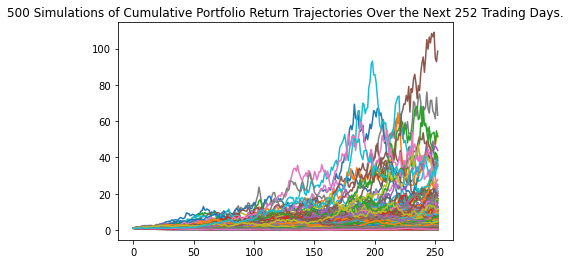

In [145]:
one_year_simulation.calc_cumulative_return()
one_year_simulation.plot_simulation()

In [ ]:
one_year_simulation.plot_distribution()

Financial Analysis

Summary Statistics


Daily Returns for 1 year

In [ ]:
# Calulate the 1 year daily returns

BTC_Daily_Returns_2021 = test_crypto_api(column='close(USD)').pct_change()

TypeError: 'DataFrame' object is not callable

In [ ]:
daily_returns_by_year = (BTC_daily_returns.groupby('timestamp').mean())

daily_returns_by_year

timestamp
2019-05-27    0.016471
2019-05-28   -0.004646
2019-05-29   -0.008027
2019-05-30   -0.043506
2019-05-31    0.034519
                ...   
2022-02-14    0.011468
2022-02-15    0.047229
2022-02-16   -0.015070
2022-02-17   -0.076535
2022-02-18    0.002696
Name: close (USD), Length: 999, dtype: float64